# Lattices

In [18]:
# file: seeq/models/lattice.py
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import LinearOperator

## Generic interface

This notebook is devoted to models of a particle hopping on an n-dimensional lattice. These models are described by a generic Hamiltonian
$$H = \sum_{\langle i,k\rangle} t_{ik}\left|i\right\rangle\left\langle{k}\right| + \sum_i \omega_i \left|i\right\rangle\left\langle{i}\right|,$$
or in second quantization speak
$$H = \sum_{\langle i,k\rangle} t_{ik}a_i^\dagger a_k + \sum_i \omega_i a_i^\dagger a_i,$$
for either bosonic or fermionic operators $\{a_i^\dagger,a_i\}.$

The description becomes simpler if we join the hopping $t$ and the local frequencies $\omega$ into a single matrix $\bar{H}_{ik}$ such that
$$H = \sum_{i,k} \bar{H}_{ik} a^\dagger_i a_k.$$
Since the matrix $\bar{H}$ is sparse, we can use Python's efficient storage methods to represent it. However, we may sometimes perform unitary transformations on the particle space, storing alternative forms of $\bar{H},$ such as its diagonal form, its spectrum or eigenmodes, or other compact representations.

Quite often, our lattice will host one or more impurities that will generically couple to the lattice sites. Those couplings will adopt the form
$$H_{int} = \sum_n O_n \sum_i (g_{n,i} a_i^\dagger + \mathrm{H.c.}),$$
where the vector of couplings $g_{ni}$ is usually determined by the "position" of the impurity $x_n.$

The generic class `Lattice()` provides an interface to both the effective Hamiltonian and the local couplings.

In [19]:
# file: seeq/models/lattice.py

class Lattice(LinearOperator):
    """Generic Lattice model with hopping/local frequencies.
    
    Properties
    ----------
    H         -- NxN matrix of tunnelings and local frequencies.
    dimension -- Dimensionality of the model.
    """
    
    def __init__(self, H, dimension=1):
        super(Lattice, self).__init__(np.float64, H.shape)
        self._H = H
        self.size = H.shape[0]
        self.dimension = dimension

    def hamiltonian(self):
        return self._H

    def coupling_at(self, r):
        """Return a vector of couplings for an impurity at position
        `r` in this generic lattice. The interpretation of `r` is
        left up to the subclass."""
        pass

    def _matvec(self, v):
        # Implement the matrix-vector multiplication
        # Inherited interface from LinearOperator()
        return self._H @ v

    def _matmat(self, A):
        # Implement the matrix-matrix multiplication
        # Inherited interface from LinearOperator()
        return self._H @ A

## Regular lattice

The following class is a generic form of `Lattice` uses a subset of points on a 1-D, 2-D or 3-D space,  but only those that satisfy a condition `f_{cond}`. In other words
$$S = \{ \vec{x}=(r_{0x}+i, r_{0y}+j, r_{0z}+k) | 0 \leq i < L_x,\, 0 \leq j < L_y,\, 0 \leq k < L_z,\;\mathrm{if}\;f_{cond}(\vec{x})=1 \}$$

The hopping is defined by a function $f_{hopping}$ that returns a list of pairs $[(J_1,\vec{y}_1),(J_2,\vec{y}_2),\ldots]$ with the neighbors of the given site and the hoppings.

This generic interface allows us to specialize one-dimensional lattices, two-dimensional square lattices, cubic and BCC lattices, with arbitrary boundaries. 

In [20]:
class Regular3DLattice(Lattice):
    """Regular lattice of equispaced points, with arbitrary connectivity and boundary.
    
    Parameters
    ----------
    sizes     -- tuple (Lx, Ly, Lz) of sizes for the lattice
    hopping   -- function of three arguments (X,Y,Z), returning a list of pairs
                 [(J, (X,Y,Z))] with the hopping and the neighbor's coordinate.
    r0        -- location of the corner (defaults to (0,0,0))
    condition -- function of three arguments (X,Y,Z), returning true if the point
                 belongs to the lattice.
    """
    
    def __init__(self, sizes, hopping, g=None, r0=(0,0,0), condition=None):
        
        if condition == None:
            condition = lambda X, Y, Z: True

        # Construct all points in this lattice
        X0, Y0, Z0 = r0
        coord = [(X,Y,Z)
                 for X in range(X0,X0+sizes[0])
                 for Y in range(Y0,Y0+sizes[1])
                 for Z in range(Z0,Z0+sizes[2])
                 if condition(X, Y, Z)]
        #
        # Assign an index to each point
        ndx_map = {vector: ndx for ndx, vector in enumerate(coord)}
        #
        # Construct the list of neighbors for each point, together
        # with their hoppings
        hops = np.array([(J, i, ndx_map[dest])
                         for i, orig in enumerate(coord)
                         for J, dest in hopping(*orig)
                         if dest in ndx_map])
        #
        # Use this information to build the sparse matrix `H` of
        # hoppings and frequencies.
        L = len(ndx_map)
        H = sp.csr_matrix((hops[:,0],(hops[:,1],hops[:,2])), shape=(L,L))
        #
        # Determine the dimensionality 
        if sizes[2] > 1:
            dimension = 3
        elif sizes[1] > 1:
            dimension = 2
        else:
            dimension = 1
        super(Regular3DLattice, self).__init__(H, dimension)
        self.coord = coord = np.array(coord)
        self.ndx_map = ndx_map
        self.Xmin = min(coord[:,0])
        self.Xmax = max(coord[:,0])
        self.Ymin = min(coord[:,1])
        self.Ymax = max(coord[:,1])
        self.Zmin = min(coord[:,2])
        self.Zmax = max(coord[:,2])

    def coupling_at(self, r, g=1.0):
        """Return vector of couplings at given position."""
        ndx = ndx_map.get(r, None)
        if ndx is None:
            raise Exception(f'Emitter position {r} is not in the lattice.')
        gr = np.zeros(self.sizeL)
        gr[ndx] = g
        return gr

    def vertex_index(self, r):
        """Return the index of position 'r' in the lattice."""
        return self.ndx_map[r]

The following is an optional function that you can import to plot the lattice structure. It is optional and separate because it relies on `mpl_toolkits`, which may or may not be installed.

In [21]:
# file: seeq/models/lattice_plot.py

import matplotlib.collections
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_lattice(L, ax=None, dot='.'):
    """Plot a 2D or 3D representation of the lattice on the given
    axis, or create one if none is given.
    
    Parameters
    ----------
    L    -- A Regular3DLattice() object
    ax   -- Axis to plot on. If None, create a new one.
    dot  -- Symbol to plot on the vertices of the lattice.
    
    Returns
    -------
    ax   -- Axis on which the figure is plot.
    """
    if ax is None:
        if L.dimension <= 2:
            fig, ax = plt.subplots()
        else:
            import mpl_toolkits.mplot3d
            fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
    #
    # We plot all the connections
    #
    H = L.hamiltonian()
    coord = L.coord
    aux = sp.coo_matrix(H)
    if L.dimension == 3:
        import mpl_toolkits.mplot3d.art3d
        lines = [(coord[a,:], coord[b,:])
                 for (a,b) in zip(aux.row, aux.col)
                 if H[a,b] != 0]
        lc = mpl_toolkits.mplot3d.art3d.Line3DCollection(lines, linewidths=0.2)
    else:
        import matplotlib.collections
        lines = [(coord[a,0:2], coord[b,0:2])
                 for (a,b) in zip(aux.row, aux.col)
                 if H[a,b] != 0]
        lc = matplotlib.collections.LineCollection(lines, linewidths=0.2)
    ax.add_collection(lc)
    #
    # First we plot all the dots that are connected to others
    #
    ndx, _ = np.nonzero(np.sum(np.abs(H), 1))
    points = coord[ndx,:]
    if L.dimension == 3:
        ax.plot(points[:,0], points[:,1], points[:,2], '.')
    else:
        ax.plot(points[:,0], points[:,1], '.')
    return ax

### a) One-dimensional lattice

In [22]:
# file: seeq/models/lattice.py

class Lattice1D(Regular3DLattice):
    """Latice for a 1D model with nearest-neighbor hoppings.
    
    Parameters
    ----------
    L         -- Lattice length (number of vertices)
    J         -- Hopping amplitude
    ω         -- Local energy on each site
    r0        -- location of the corner (defaults to (0,0,0))
    """

    def __init__(self, L, J=1, ω=1, **kwdargs):
        
        def hopping1d(X, Y, Z):
            return [(ω, (X,Y,Z)), (J, (X+1,Y,Z)), (J, (X-1,Y,Z))]

        super(Lattice1D, self).__init__([L,1,1], hopping1d, **kwdargs)
        self.J = J
        self.ω = ω

A 1D lattice produces a tridiagonal matrix

In [23]:
print(Lattice1D(10, J=-1.0, ω=2.0).hamiltonian().todense())

[[ 2. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  2.]]


When plotted, we have just a 1D line.

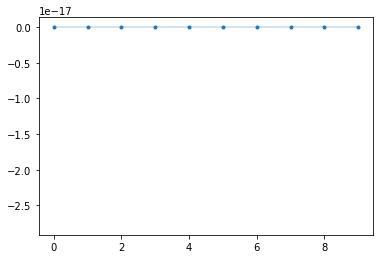

In [24]:
plot_lattice(Lattice1D(10));

### b) Two-dimensional square lattice

In [25]:
# file: seeq/models/lattice.py

class SquareLattice(Regular3DLattice):
    """Latice for a 2D model with nearest-neighbor hoppings.
    
    Parameters
    ----------
    Lx, Ly    -- Lattice length (number of vertices). Ly defaults to Lx
    Jx, Jy    -- hopping amplitudes (Jy defaults to Jx, Jx defaults to 1)
    ω         -- Local energy on each site
    r0        -- location of the corner (defaults to (0,0,0))
    """

    def __init__(self, Lx, Ly=None, Jx=1.0, Jy=None, ω=1, **kwdargs):
        
        if Ly is None:
            Ly = Lx
        if Jy is None:
            Jy = Jx

        def hopping2d(X, Y, Z):
            return [(ω, (X,Y,Z)), (Jx, (X+1,Y,Z)), (Jx, (X-1,Y,Z)), (Jy, (X,Y+1,Z)), (Jy, (X,Y-1,Z))]

        super(SquareLattice, self).__init__([Lx,Ly,1], hopping2d, **kwdargs)
        self.J = (Jx, Jy)
        self.ω = ω

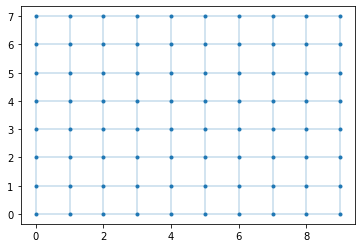

In [26]:
plot_lattice(SquareLattice(Lx=10, Ly=8, Jx=1, Jy=1));

## c) Rhombus

In [27]:
# file: seeq/models/lattice.py

class RhombusLattice(Regular3DLattice):
    """Latice for a 2D model with nearest-neighbor hoppings and a boundary
    that resembles a Rhombus
    
    Parameters
    ----------
    L         -- Lattice length (number of vertices)
    Jx, Jy    -- hopping amplitudes (Jy defaults to Jx, Jx defaults to 1)
    ω         -- Local energy on each site
    r0        -- Center of the rombus
    """

    def __init__(self, L, Jx=1.0, Jy=None, ω=1, r0=(0,0,0), **kwdargs):
        if Jy is None:
            Jy = Jx

        X0, Y0, Z0 = r0
        r0 = (X0 - L, Y0 - L, Z0)

        def hopping2d(X, Y, Z):
            return [(ω, (X,Y,Z)), (Jx, (X+1,Y,Z)), (Jx, (X-1,Y,Z)), 
                    (Jy, (X,Y+1,Z)), (Jy, (X,Y-1,Z))]

        def condition(X, Y, Z):
            X -= X0
            Y -= Y0
            return ((np.abs(X-Y) <= L) & (np.abs(X+Y) <= L))+0

        super(RhombusLattice, self).__init__([2*L+1,2*L+1,1], hopping2d, r0=r0,
                                             condition=condition, **kwdargs)
        self.J = (Jx, Jy)
        self.ω = ω

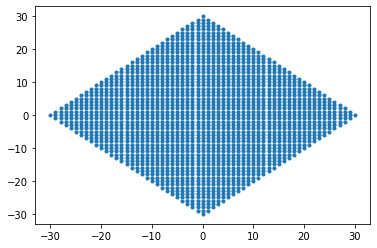

In [28]:
plot_lattice(RhombusLattice(30));

### d) Cubic lattice

In [29]:
# file: seeq/models/lattice.py

class CubicLattice(Regular3DLattice):
    """Latice for a 3D model with a cubic lattice.
    
    Parameters
    ----------
    Lx, Ly, Lz -- Lattice length (number of vertices, Ly and Lz default to Lx)
    Jx, Jy, Jx -- hopping amplitudes (Jx defaults to 1, Jy and Jz default to Jx)
    ω          -- Local energy on each site
    r0         -- Corner of the cube
    """

    def __init__(self, Lx, Ly=None, Lz=None, Jx=1.0, Jy=None, Jz=None, ω=1, **kwdargs):
        if Ly is None:
            Ly = Lx
        if Lz is None:
            Lz = Lx
        if Jy is None:
            Jy = Jx
        if Jz is None:
            Jz = Jx

        def hopping3d(X, Y, Z):
            return [(ω, (X,Y,Z)),
                    (Jx, (X+1,Y,Z)), (Jx, (X-1,Y,Z)),
                    (Jy, (X,Y+1,Z)), (Jy, (X,Y-1,Z)),
                    (Jz, (X,Y,Z+1)), (Jz, (X,Y,Z-1))]

        super(CubicLattice, self).__init__([Lx,Ly,Lz], hopping3d, **kwdargs)
        self.J = (Jx, Jy, Jz)
        self.ω = ω

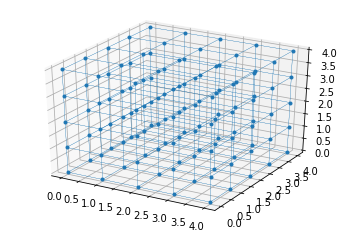

In [30]:
plot_lattice(CubicLattice(Lx=5, Jx=1));

### e) BCC Lattice

In [31]:
# file: seeq/models/lattice.py

class BCCLattice(Regular3DLattice):
    """Latice for a 3D model with a BCC lattice.
    
    Parameters
    ----------
    Lx, Ly, Lz -- Lattice length (number of vertices, Ly and Lz default to Lx)
    J          -- hopping amplitudes (defaults to 1)
    ω          -- Local energy on each site
    r0         -- Corner of the cube
    """

    def __init__(self, Lx, Ly=None, Lz=None, J=1.0, ω=1, **kwdargs):
        if Ly is None:
            Ly = Lx
        if Lz is None:
            Lz = Lx

        def bcc_hopping(X, Y, Z):
            return [(ω, (X,Y,Z)),
                     (J, (X+1,Y+1,Z+1)), (J, (X-1,Y-1,Z+1)),
                     (J, (X+1,Y-1,Z+1)), (J, (X-1,Y+1,Z+1)),
                     (J, (X+1,Y+1,Z-1)), (J, (X-1,Y-1,Z-1)),
                     (J, (X+1,Y-1,Z-1)), (J, (X-1,Y+1,Z-1))]

        def bcc_condition(X, Y, Z):
            dX = X % 2
            dY = Y % 2
            dZ = Z % 2
            return (dX == dY) and (dX == dZ)

        super(BCCLattice, self).__init__([Lx, Ly, Lz], bcc_hopping,
                                         condition=bcc_condition, **kwdargs)
        self.J = J
        self.ω = ω

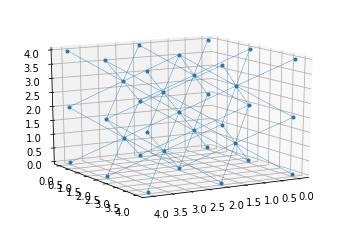

In [32]:
plot_lattice(BCCLattice(5)).view_init(elev=15., azim=60)

## Examples

### a) Evolution of a wavepacket in 1D

We create a wavepacket with fixed width $\sigma$ and momentum $k,$ on a 1D lattice and study its evolution. The initial state reads
$$\psi_r = \frac{1}{\sqrt{N}} \exp\left(-\frac{(r-x_0)^2}{2\sigma^2} - i k r\right),\;r=0,1,\ldots,L-1.$$

The evolution is performed with the hopping Hamiltonian, which in this case is the simple Schrödinger equation $(\hbar=1)$
$$i\partial_t \vec{\psi} = \bar{H} \vec{\psi}.$$

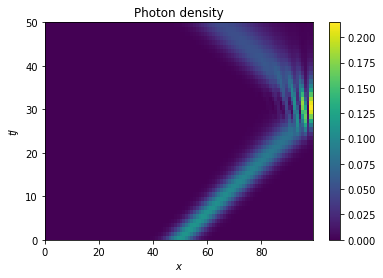

In [61]:
from seeq.evolution import evolve

def test_wavepacket(L=100, x0=50, σ=5, k=1, t=50, steps=51):
    #
    # Positions and initial conditions
    x = np.arange(L)
    ψ0 = np.exp(-(x-x0)**2/(2*σ**2) - 1j*k*x)
    ψ0 /= np.linalg.norm(ψ0)
    #
    # Model for a 1D lattice
    H = Lattice1D(L, J=1.)
    #
    # Time intervals where the function is evaluated
    times = np.linspace(0, t, steps)

    ρt = np.array([np.abs(ψ)**2 for t, ψ
                   in evolve(ψ0, H, times, constant=True)])
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,4))
    X, Y = np.meshgrid(x, times)

    c = ax.pcolor(X, Y, ρt)
    ax.set_title('Photon density')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t J$')
    plt.colorbar(c)

test_wavepacket()

Notice how changing the momentum changes the speed. This is because we are working with a finite-bandwidth lattice that has a non-uniform group velocity.

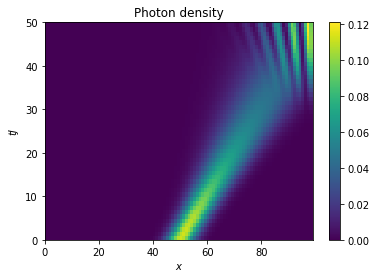

In [63]:
test_wavepacket(k=0.5)